# Playing CartPole with the Actor-Critic Method (Total 70 points)


This notebook demonstrates how to implement the [Actor-Critic](https://papers.nips.cc/paper/1786-actor-critic-algorithms.pdf) method using TensorFlow to train an agent on the [Open AI Gym](https://gym.openai.com/) CartPole-V0 environment.
The reader is assumed to have some familiarity with [policy gradient methods](https://papers.nips.cc/paper/1713-policy-gradient-methods-for-reinforcement-learning-with-function-approximation.pdf) of reinforcement learning. 


**Actor-Critic methods**

Actor-Critic methods are [temporal difference (TD) learning](https://en.wikipedia.org/wiki/Temporal_difference_learning) methods that represent the policy function independent of the value function. 

A policy function (or policy) returns a probability distribution over actions that the agent can take based on the given state.
A value function determines the expected return for an agent starting at a given state and acting according to a particular policy forever after.

In the Actor-Critic method, the policy is referred to as the *actor* that proposes a set of possible actions given a state, and the estimated value function is referred to as the *critic*, which evaluates actions taken by the *actor* based on the given policy.

In this notebook, both the *Actor* and *Critic* will be represented using one neural network with two outputs.


**CartPole-v0**

In the [CartPole-v0 environment](https://gym.openai.com/envs/CartPole-v0), a pole is attached to a cart moving along a frictionless track. 
The pole starts upright and the goal of the agent is to prevent it from falling over by applying a force of -1 or +1 to the cart. 
A reward of +1 is given for every time step the pole remains upright.
An episode ends when (1) the pole is more than 15 degrees from vertical or (2) the cart moves more than 2.4 units from the center.

The problem is considered "solved" when the average total reward for the episode reaches 195 over 100 consecutive trials.

## Setup

Import necessary packages and configure global settings.


In [23]:
%%bash
pip install gym[classic_control]
pip install gym
pip install pyglet

sudo apt-get install -y xvfb python-opengl > /dev/null 2>&1
pip install pyvirtualdisplay > /dev/null 2>&1
pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import collections, statistics
from typing import Any, List, Sequence, Tuple
import numpy as np
from matplotlib import pyplot as plt
import tqdm
import gym

import torch
import torch.nn as nn

# Create the environment
env = gym.make("CartPole-v0")

# Set seed for experiment reproducibility
seed = 42
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

device = 'cuda' if torch.cuda.is_available else 'cpu'

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:594: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {id} is out of date. You should consider "
/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in futu

## Model
### Fill in the blanks: 30 points

The *Actor* and *Critic* will be modeled using one neural network that generates the action probabilities and critic value respectively. 

During the forward pass, the model will take in the state as the input and will output both action probabilities and critic value $V$, which models the state-dependent [value function](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#value-functions). The goal is to train a model that chooses actions based on a policy $\pi$ that maximizes expected [return](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#reward-and-return).

For Cartpole-v0, there are four values representing the state: cart position, cart-velocity, pole angle and pole velocity respectively. The agent can take two actions to push the cart left (0) and right (1) respectively.

Refer to [OpenAI Gym's CartPole-v0 wiki page](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf) for more information.


In [15]:
class ActorCritic(nn.Module):
  """Combined actor-critic network."""

  def __init__(
      self, 
      num_actions: int, 
      num_hidden_units: int,
      in_features: int = 4):
    """Initialize."""
    super().__init__()
    ##########################################################Start you code here#####################################################################
    # 30 points
    # Add three lines; each line defines a nn.Linear layer; the three layers are named as self.common, self.actor, self.critic
    # For self.common layer, in_features = in_features, out_features = num_hidden_units; all other arguments are default values
    # For self.actor layer, in_features = num_hidden_units, out_features = num_actions; all other arguments are default values
    # For self.critic layer, in_features = num_hidden_units, out_features = 1; all other arguments are default values

    self.common = nn.Linear(in_features = in_features, out_features = num_hidden_units)
    self.actor = nn.Linear(in_features = num_hidden_units, out_features = num_actions)
    self.critic = nn.Linear(in_features = num_hidden_units, out_features = 1)



    ###########################################################End you code###########################################################################

  def forward(self, inputs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    x = nn.functional.relu(self.common(inputs))
    return self.actor(x), self.critic(x)

In [16]:
num_actions = env.action_space.n  # 2
num_hidden_units = 128

model = ActorCritic(num_actions, num_hidden_units).to(device)

## Training

To train the agent, you will follow these steps:

1. Run the agent on the environment to collect training data per episode.
2. Compute expected return at each time step.
3. Compute the loss for the combined actor-critic model.
4. Compute gradients and update network parameters.
5. Repeat 1-4 until either success criterion or max episodes has been reached.


### 1. Collecting training data

As in supervised learning, in order to train the actor-critic model, you need
to have training data. However, in order to collect such data, the model would
need to be "run" in the environment.

Training data is collected for each episode. Then at each time step, the model's forward pass will be run on the environment's state in order to generate action probabilities and the critic value based on the current policy parameterized by the model's weights.

The next action will be sampled from the action probabilities generated by the model, which would then be applied to the environment, causing the next state and reward to be generated.

This process is implemented in the `run_episode` function.

In [17]:
# Wrap OpenAI Gym's `env.step` call as an operation in a function.

def env_step(action: np.ndarray) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
  """Returns state, reward and done flag given an action."""

  state, reward, done, _ = env.step(action)
  return (torch.from_numpy(state.astype(np.float32)).to(device), 
          torch.from_numpy(np.array(reward, np.int32)).to(device), 
          torch.from_numpy(np.array(done, np.int32)).to(device))

def run_episode(
    initial_state: torch.Tensor,  
    model: nn.Module, 
    max_steps: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
  """Runs a single episode to collect training data."""

  action_probs = []
  values = []
  rewards = []

  initial_state_shape = initial_state.shape
  state = initial_state

  for t in range(max_steps):
    # Convert state into a batched tensor (batch size = 1)
    state = torch.unsqueeze(state, 0)
  
    # Run the model and to get action probabilities and critic value
    action_logits_t, value = model(state)
  
    # Sample next action from the action probability distribution
    m = torch.distributions.categorical.Categorical(logits=action_logits_t)
    action = m.sample().item()
    action_probs_t = torch.nn.functional.softmax(action_logits_t, dim=1)

    # Store critic values
    values.append(value.squeeze())

    # Store probability of the action chosen
    action_probs.append(action_probs_t[0, action])
  
    # Apply action to the environment to get next state and reward
    state, reward, done = env_step(action)
    state = state.reshape(initial_state_shape)
  
    # Store reward
    rewards.append(reward)

    if done:
      break

  action_probs = torch.stack(action_probs, dim=0)
  values = torch.stack(values, dim=0)
  rewards = torch.stack(rewards, dim=0)
  
  return action_probs, values, rewards

### 2. Computing expected returns

The sequence of rewards for each timestep $t$, $\{r_{t}\}^{T}_{t=1}$ collected during one episode is converted into a sequence of expected returns $\{G_{t}\}^{T}_{t=1}$ in which the sum of rewards is taken from the current timestep $t$ to $T$ and each reward is multiplied with an exponentially decaying discount factor $\gamma$:

$$G_{t} = \sum^{T}_{t'=t} \gamma^{t'-t}r_{t'}$$

Since $\gamma\in(0,1)$, rewards further out from the current timestep are given less weight.

Intuitively, expected return simply implies that rewards now are better than rewards later. In a mathematical sense, it is to ensure that the sum of the rewards converges.

To stabilize training, the resulting sequence of returns is also standardized (i.e. to have zero mean and unit standard deviation).


In [18]:
def get_expected_return(
    rewards: torch.Tensor, 
    gamma: float, 
    standardize: bool = True) -> torch.Tensor:
  """Compute expected returns per timestep."""

  n = rewards.shape[0]
  returns = []

  # Start from the end of `rewards` and accumulate reward sums
  # into the `returns`
  discounted_sum = 0
  for i in reversed(range(n)):
    reward = rewards[i]
    discounted_sum = reward + gamma * discounted_sum
    returns.append(discounted_sum)
  returns = torch.stack(returns[::-1], dim=0)

  if standardize:
    returns = ((returns - returns.mean()) / 
               (returns.std() + eps))

  return returns

### 3. The actor-critic loss

Since a hybrid actor-critic model is used, the chosen loss function is a combination of actor and critic losses for training, as shown below:

$$L = L_{actor} + L_{critic}$$

#### Actor loss

The actor loss is based on [policy gradients with the critic as a state dependent baseline](https://www.youtube.com/watch?v=EKqxumCuAAY&t=62m23s) and computed with single-sample (per-episode) estimates.

$$L_{actor} = -\sum^{T}_{t=1} \log\pi_{\theta}(a_{t} | s_{t})[G(s_{t}, a_{t})  - V^{\pi}_{\theta}(s_{t})]$$

where:
- $T$: the number of timesteps per episode, which can vary per episode
- $s_{t}$: the state at timestep $t$
- $a_{t}$: chosen action at timestep $t$ given state $s$
- $\pi_{\theta}$: is the policy (actor) parameterized by $\theta$
- $V^{\pi}_{\theta}$: is the value function (critic) also parameterized by $\theta$
- $G = G_{t}$: the expected return for a given state, action pair at timestep $t$

A negative term is added to the sum since the idea is to maximize the probabilities of actions yielding higher rewards by minimizing the combined loss.

<br>

##### Advantage

The $G - V$ term in our $L_{actor}$ formulation is called the [advantage](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#advantage-functions), which indicates how much better an action is given a particular state over a random action selected according to the policy $\pi$ for that state.

While it's possible to exclude a baseline, this may result in high variance during training. And the nice thing about choosing the critic $V$ as a baseline is that it trained to be as close as possible to $G$, leading to a lower variance.

In addition, without the critic, the algorithm would try to increase probabilities for actions taken on a particular state based on expected return, which may not make much of a difference if the relative probabilities between actions remain the same.

For instance, suppose that two actions for a given state would yield the same expected return. Without the critic, the algorithm would try to raise the probability of these actions based on the objective $J$. With the critic, it may turn out that there's no advantage ($G - V = 0$) and thus no benefit gained in increasing the actions' probabilities and the algorithm would set the gradients to zero.

<br>

#### Critic loss

Training $V$ to be as close possible to $G$ can be set up as a regression problem with the following loss function:

$$L_{critic} = L_{\delta}(G, V^{\pi}_{\theta})$$

where $L_{\delta}$ is the [Huber loss](https://en.wikipedia.org/wiki/Huber_loss), which is less sensitive to outliers in data than squared-error loss.


In [19]:
huber_loss = torch.nn.HuberLoss(reduction='sum')

def compute_loss(
    action_probs: torch.Tensor,  
    values: torch.Tensor,  
    returns: torch.Tensor) -> torch.Tensor:
  """Computes the combined actor-critic loss."""

  advantage = returns - values

  action_log_probs = action_probs.log()
  actor_loss = -(action_log_probs * advantage).sum()

  critic_loss = huber_loss(values, returns)

  return actor_loss + critic_loss

### 4. Defining the training step to update parameters 
### Fill in the blanks: 40 points

All of the steps above are combined into a training step that is run every episode. All steps leading up to the loss function are executed with the `tf.GradientTape` context to enable automatic differentiation.

This notebook uses the Adam optimizer to apply the gradients to the model parameters.

The sum of the undiscounted rewards, `episode_reward`, is also computed in this step. This value will be used later on to evaluate if the success criterion is met.

The `tf.function` context is applied to the `train_step` function so that it can be compiled into a callable TensorFlow graph, which can lead to 10x speedup in training.


In [20]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)

def train_step(
    initial_state: torch.Tensor, 
    model: nn.Module, 
    optimizer: torch.optim.Optimizer, 
    gamma: float, 
    max_steps_per_episode: int) -> torch.Tensor:
  """Runs a model training step."""

  # Run the model for one episode to collect training data
  action_probs, values, rewards = run_episode(
      initial_state, model, max_steps_per_episode) 

  #############################################################Start your code here#########################################################################
  # 10 points
  # One single line
  # Calculate expected returns
  # Call get_expected_return function defined above
  returns = get_expected_return(rewards, gamma)

  
  ##################################################################End your code###########################################################################

  # Convert training data to appropriate torch tensor shapes
  action_probs, values, returns = [
      torch.unsqueeze(x, 1) for x in [action_probs, values, returns]] 

  #############################################################Start your code here#########################################################################
  # 10 points
  # One single line
  # Calculating loss values to update our network
  # Call compute_loss function defined above

  loss = compute_loss(action_probs, values, returns)

  


  ##################################################################End your code###########################################################################
  
  #############################################################Start your code here#########################################################################
  # 20 points
  # Three lines: call zero_grad(), backward(), and step(); You need to figure out how to call these three functions; Hint: it is very simple
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  



  ##################################################################End your code###########################################################################

  episode_reward = rewards.sum()

  return episode_reward

### 5. Run the training loop

Training is executed by running the training step until either the success criterion or maximum number of episodes is reached.  

A running record of episode rewards is kept in a queue. Once 100 trials are reached, the oldest reward is removed at the left (tail) end of the queue and the newest one is added at the head (right). A running sum of the rewards is also maintained for computational efficiency. 

Depending on your runtime, training can finish in less than a minute.

In [21]:
%%time

min_episodes_criterion = 100
max_episodes = 10000
max_steps_per_episode = 1000

# Cartpole-v0 is considered solved if average reward is >= 195 over 100 
# consecutive trials
reward_threshold = 195
running_reward = 0

# Discount factor for future rewards
gamma = 0.99

# Keep last episodes reward
episodes_reward: collections.deque = collections.deque(maxlen=min_episodes_criterion)

with tqdm.trange(max_episodes) as t:
  for i in t:
    initial_state = torch.from_numpy(np.array(env.reset(), dtype=np.float32)).to(device)
    episode_reward = int(train_step(
        initial_state, model, optimizer, gamma, max_steps_per_episode))
    
    episodes_reward.append(episode_reward)
    running_reward = statistics.mean(episodes_reward)
  
    t.set_description(f'Episode {i}')
    t.set_postfix(
        episode_reward=episode_reward, running_reward=running_reward)
  
    # Show average episode reward every 10 episodes
    if i % 10 == 0:
      pass # print(f'Episode {i}: average reward: {avg_reward}')
  
    if running_reward > reward_threshold and i >= min_episodes_criterion:  
        break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

Episode 672:   7%|▋         | 672/10000 [01:55<26:44,  5.81it/s, episode_reward=200, running_reward=195]


Solved at episode 672: average reward: 195.46!
CPU times: user 1min 52s, sys: 952 ms, total: 1min 53s
Wall time: 1min 55s


## Visualization

After training, it would be good to visualize how the model performs in the environment. You can run the cells below to generate a GIF animation of one episode run of the model. Note that additional packages need to be installed for OpenAI Gym to render the environment's images correctly in Colab.

In [24]:
# Render an episode and save as a GIF file

from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display


display = Display(visible=0, size=(400, 300))
display.start()


def render_episode(env: gym.Env, model: nn.Module, max_steps: int): 
  screen = env.render(mode='rgb_array')
  im = Image.fromarray(screen)

  images = [im]
  
  state = torch.from_numpy(env.reset().astype(np.float32)).to(device)
  for i in range(1, max_steps + 1):
    state = state.unsqueeze(0)
    action_probs, _ = model(state)
    action = action_probs.squeeze().argmax().item()

    state, _, done, _ = env.step(action)
    state = torch.from_numpy(state).to(device).float()

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render(mode='rgb_array')
      images.append(Image.fromarray(screen))
  
    if done:
      break
  
  return images


# Save GIF image
images = render_episode(env, model, max_steps_per_episode)
image_file = 'cartpole-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)

/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "



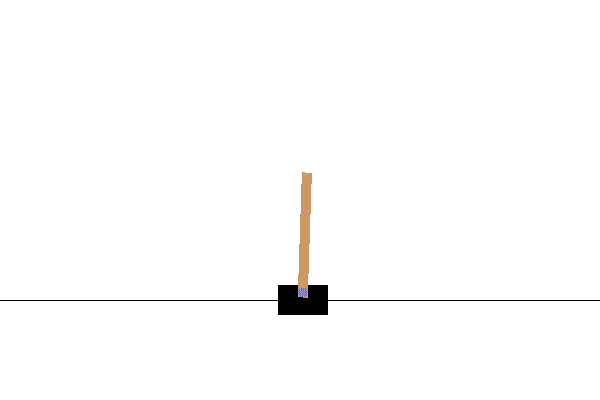

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)